In [1]:
#using TaylorSeries
include("UndrivenHelium.jl")
#include("Integ.jl")
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false, size=(600,600), color=:black, markersize = 0.3 )
const Z = 2.0
const order = 34
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000

500000

## Revisamos compatibilidad hamiltoniano vs ecs de movimiento

  3.614154 seconds (24.65 M allocations: 1.317 GiB, 14.50% gc time)



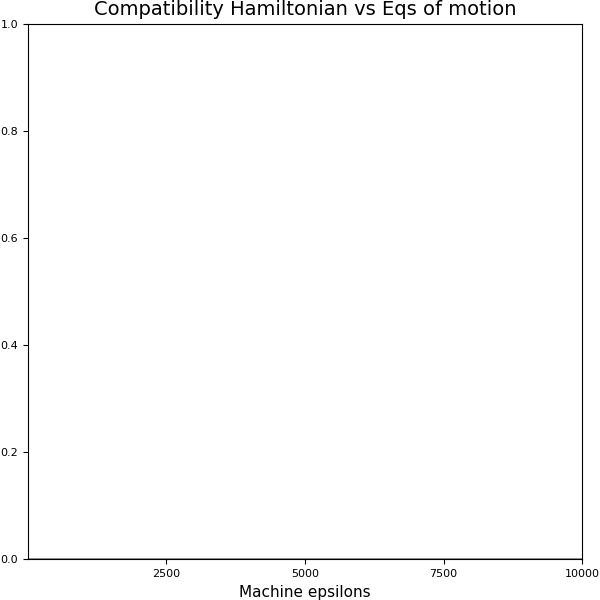

In [2]:
@time dnorm, als= errHam1D(10_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")
xaxis!("Machine epsilons")

# Incluimos funciones para obtener secciones de Poincaré

In [3]:
include("Integ.jl")

taylorintegps (generic function with 1 method)

In [4]:
c1 = condini1D(5.0, 0.0)

4-element Array{Float64,1}:
 2.23607
 0.0    
 0.0    
 4.0    

In [5]:
t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

  0.808109 seconds (5.11 M allocations: 582.264 MiB, 24.13% gc time)


In [6]:
t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

In [7]:
length(t1), length(t2)

(1572, 1732)

In [8]:
ene1 = zeros(t1)
ene2 = zeros(t2)
for j in eachindex(ene1)
    ene1[j] = abs(regHam1D(x1[j,:]))/eps()
end
for j in eachindex(ene2)
    ene2[j] = abs(regHam1D(x2[j,:]))/eps()
end


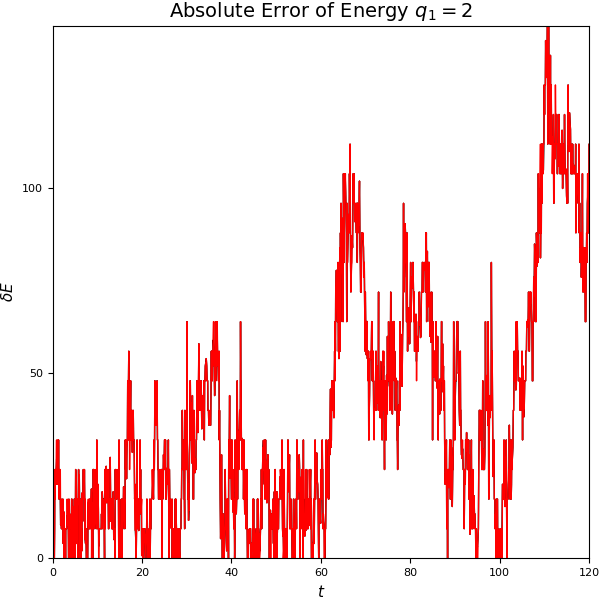

In [9]:
plot(t1, ene1, title =L"Absolute Error of Energy $q_1=2$", color = :black)
plot!(t2, ene2, title =L"Absolute Error of Energy $q_1=2$",color=:red, label=L"Cálculo con Sección de Poincaré")
xaxis!(L"t")
yaxis!(L"\delta E")



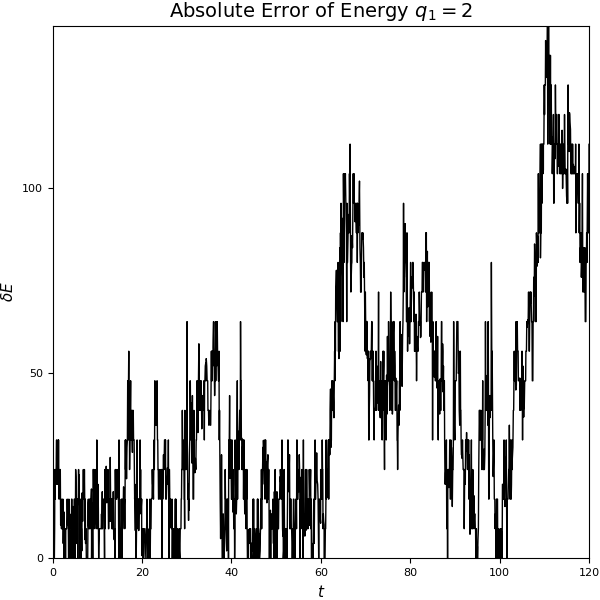

In [10]:
plot(t2, ene2, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [11]:
maximum(ene1)

144.0

# Implementamos funciones para obtener gráficas de las secciones de Poincaré

In [12]:
function psundriven{T<:Number}(x10::T, px10::T; tol::Float64 = 1e-20, tmax = 100.0, maxsteps1 = 5_000 )
    c1 = condini1D(x10, px10)
    t, x, tp, xp = taylorintegps(undrivenHelium1D!, c1, t0, tmax, order, abs_tol; maxsteps = maxsteps1)
    
    xpm = similar(xp)
    xpm[:,1] = map(ks, xp[:,1])
    xpm[:,3] = Float64[ksv(xp[k,1], xp[k, 3]) for k in eachindex(tp)]
    xpm[:,2] = map(ks, xp[:,2])
    xpm[:,4] = Float64[ksv(xp[k,2], xp[k, 4]) for k in eachindex(tp)]

    return xpm, t, x
end

psundriven (generic function with 1 method)

In [13]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreps(n::Int) = Symbol( string("ps", n) )
nombreq(n::Int) = Symbol( string("q", n) )
nombrexs(n::Int) = Symbol( string("xs", n) )
nombrevxs(n::Int) = Symbol( string("vxs", n) )
nombreys(n::Int) = Symbol( string("ys", n) )
nombrevys(n::Int) = Symbol( string("vys", n) )

function orbits(nmin, rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = nmin:(N+nmin - 1)
        ex1 = quote 
            $(nombreps(j)), $(nombret(j)), $(nombreq(j))  = 
                psundriven(Float64($(rs[j])), 0.0; tmax = 100.0, maxsteps1 = 5_000 )
             end
        ex2 = quote 
                $(nombrexs(j)) = $(nombreps(j))[:,1]
             end
        
        ex3 = quote 
                 $(nombrevxs(j)) =  $(nombreps(j))[:,3]
             end
        ex4 = quote 
                $(nombreps(j))[:,2]
             end
        
        ex5 = quote 
                $(nombreps(j))[:,4]
             end
        eval(ex1)
        eval(ex2)
        eval(ex3)
        eval(ex4)
        eval(ex5)
    end
end

function plottingps(nmax,xmin::Float64=0.0, xmax::Float64=20.0, 
    ymin::Float64=-1.0, ymax::Float64=1.0)
    scatter(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
    for j in 2:nmax
        ex = quote
            scatter!($(nombrexs(j)), $(nombrevxs(j)))
        end
        eval(ex)
    end
    xaxis!([0,20])
    xlabel!(L"x")
    ylabel!(L"p_x")
    yaxis!([ymin, ymax])
    xaxis!([xmin, xmax])
end

function ksv(Q, P)
    v₁ = P/2Q
    return v₁
end
ks(Q) = Q^2

ks (generic function with 1 method)

In [14]:
@time orbits(1,2:0.1:10)
NM = length(2:0.1:10)

 49.611903 seconds (471.10 M allocations: 52.069 GiB, 22.92% gc time)


  0.706321 seconds (388.53 k allocations: 18.967 MiB, 1.08% gc time)



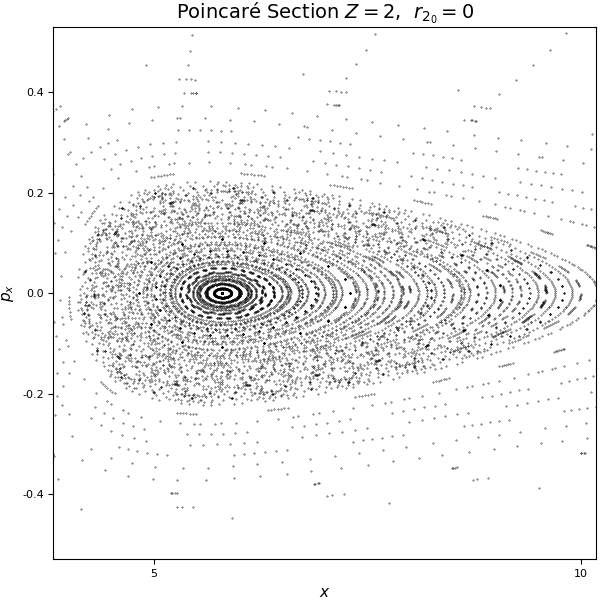

In [15]:
@time plottingps(NM, 4.0, 10., -.5, .5)
#@time plottingps(NM, 0., 4., -0.5, 0.5)

In [50]:
xtemp0

4-element Array{Float64,1}:
 2.4084
 0.0   
 0.0   
 4.0   

In [49]:
xtemp0 = condini1D(x0...)
xtemp = Float64[ks(xtemp0[1]),ks(xtemp0[2]), ksv(xtemp0[1], xtemp0[3]), ksv(xtemp0[2], xtemp0[4])]

4-element Array{Float64,1}:
   5.8004
   0.0   
   0.0   
 Inf     

In [68]:
mod(101,100)

1

In [93]:
nconds = 2000

xvSv = Array{Float64,2}[]
x0 = Float64[5.8004, 0.0]
circ_inis = Array{Array{Float64,1},1}(nconds)
circ_inis[1] = x0
for i in 2:nconds
    rand1 = rand(); rand2 = rand()
    x_ini = x0 + 0.00000005*[rand1*cos(2pi*rand2),rand1*sin(2pi*rand2)]
    circ_inis[i] = x_ini
end
contador = 0
@time for x in circ_inis
    xtemp = Float64[x[1], 0.0, x[2], Inf]
    xp, t, xt = psundriven(x[1], x[2]; tmax = 120.0, maxsteps1 = 5_000 )
    push!(xvSv, vcat(xtemp', xp))
    contador += 1
    if mod(contador, 100) == 0
        println(string(contador), "de 2000")
    end
end

nconds = 100

xvSv2 = Array{Float64,2}[]
per_inis = Array{Array{Float64,1},1}(nconds)
for i in 1:nconds
    rand2 = rand()
    x_ini = x0 + 0.00000005*[cos(2pi*rand2),sin(2pi*rand2)]
    per_inis[i] = x_ini
end
@time for x in per_inis
    xtemp = Float64[x[1], 0.0, x[2], Inf]
    xp, t, xt = psundriven(x[1], x[2]; tmax = 120.0, maxsteps1 = 5_000 )
    push!(xvSv2, vcat(xtemp', xp))
end

100de 2000
200de 2000
300de 2000
400de 2000
500de 2000
600de 2000
700de 2000
800de 2000
900de 2000
1000de 2000
1100de 2000
1200de 2000
1300de 2000
1400de 2000
1500de 2000
1600de 2000
1700de 2000
1800de 2000
1900de 2000
2000de 2000
1061.497271 seconds (10.26 G allocations: 1.108 TiB, 24.02% gc time)
 52.569081 seconds (512.96 M allocations: 56.726 GiB, 24.40% gc time)


In [97]:
nconds = 500

xvSv2 = Array{Float64,2}[]
per_inis = Array{Array{Float64,1},1}(nconds)
for i in 1:nconds
    rand2 = rand()
    x_ini = x0 + 0.00000005*[cos(2pi*rand2),sin(2pi*rand2)]
    per_inis[i] = x_ini
end
@time for x in per_inis
    xtemp = Float64[x[1], 0.0, x[2], Inf]
    xp, t, xt = psundriven(x[1], x[2]; tmax = 120.0, maxsteps1 = 5_000 )
    push!(xvSv2, vcat(xtemp', xp))
end

264.820121 seconds (2.56 G allocations: 283.633 GiB, 24.54% gc time)


In [98]:
#Salvamos soluciones en archivos de texto
contador = 1
for x in xvSv
    dir =string("MonteCarlo/xvSv",string(contador),".csv")
    writecsv(dir, x)
    contador += 1
end

contador = 1
for x in xvSv2
    dir =string("Circ/xvSv",string(contador),".csv")
    writecsv(dir, x)
    contador += 1
end

In [96]:
pyplot()
poincareuh = @animate for i=1:157
    scatter(map(x->x[i,1], xvSv), map(x->x[i,3], xvSv), label="$(i-1)-th iterate", m=(1,stroke(0)))
    xlims!(5.8003997,5.8004053)
    ylims!(-0.00000025,0.00000025)
    xlabel!("x")
    ylabel!("pₓ")
    title!("Undriven Helium Poincaré map near at point (5.8004, 0.0)")
end
gif(poincareuh, "./poincareuh.gif", fps = 2)

INFO: Saved animation to /home/daniel/Documents/2017-2/Tesis/UndrivenHelium/TaylorIntegration/poincareuh.gif


Plots.AnimatedGif("/home/daniel/Documents/2017-2/Tesis/UndrivenHelium/TaylorIntegration/poincareuh.gif")

  0.102218 seconds (160.39 k allocations: 6.730 MiB, 18.06% gc time)



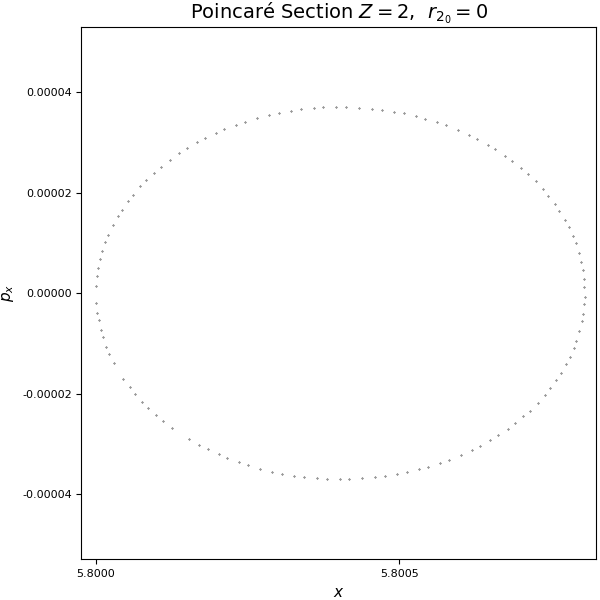

In [19]:
@time plottingps(NM, 5.8, 5.8008, -0.00005, 0.00005)

La aproximación a ojo es mala, por ello, se usará un Método de Newton modificado para calcular el ciclo estable, usando jet transport (necesitamos una precisión del orden $\sim10^{-14}$)